In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

In [9]:
torch.log(torch.Tensor([1e-30]))

tensor([-69.0776])

In [2]:
class Scaled_softplus(nn.Module):
    def __init__(self):
        super().__init__()
        self.s = Parameter(torch.ones(1))
    def forward(self, x):
        return self.s*torch.log(1+torch.exp(x/self.s))

class LSTM_point_process(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,\
                 batch_first = True, dropout = 0, bidirectional = False):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,\
                            batch_first = batch_first, dropout = dropout,\
                            bidirectional = bidirectional)
        if bidirectional:
            self.hidden0 = Parameter(torch.randn(num_layers*2, hidden_size))
            self.cell0 = Parameter(torch.randn(num_layers*2, hidden_size))
            self.W = Parameter(torch.randn(hidden_size*2, num_classes))
        else:
            self.hidden0 = Parameter(torch.randn(num_layers, hidden_size))
            self.cell0 = Parameter(torch.randn(num_layers, hidden_size))
            self.W = Parameter(torch.randn(hidden_size, num_classes))
        self.f = Scaled_softplus()
        self.num_classes = num_classes
        self.bidir = bidirectional
        
    def forward(self, s, provide_states = False):
        bs, seq_len, _ = s.shape
        hidden0 = self.hidden0[:,None,:].repeat(1,bs,1)
        cell0 = self.cell0[:,None,:].repeat(1,bs,1)
        out, (hidden, cell) = self.lstm(s, (hidden0, cell0))
        lambdas = torch.zeros(bs,seq_len, self.num_classes)
        if self.bidir:
            h0 = hidden0[-3:, 0, :].reshape(-1)
        else:
            h0 = hidden0[-1, 0, :].reshape(-1)
        lambdas[:,0,:] = self.f(h0 @ self.W)[None,:].repeat(bs,1)
        lambdas[:,1:,:] = self.f(out[:,:-1,:] @ self.W)
        if provide_states:
            return lambdas, hidden, cell
        return lambdas
    
    def simulate(self, batch_size, dt, seq_len, verbose = False):
        with torch.no_grad():
            self.eval()
            res = torch.zeros(batch_size, seq_len, 1+self.num_classes)
            hidden0 = self.hidden0[:,None,:]
            cell0 = self.cell0[:,None,:]
            for b in range(batch_size):
                if verbose == True:
                    print('Generating batch {}/{}'.format(b+1, batch_size))
                for s in range(seq_len):
                    if verbose and s%100==0:
                        print('>>> Generating sequence step {}/{}'.format(s+1, seq_len))
                    if s == 0:
                        if self.bidir:
                            h0 = hidden0[-3:, :, :].reshape(-1)
                        else:
                            h0 = hidden0[-1, :, :].reshape(-1)
                        lambdas = self.f(h0 @ self.W)
                        res[b, s, 1:] = torch.poisson(lambdas*dt[b])
                        res[b, s, 0]  = dt[b]
                        hidden = hidden0.clone()
                        cell = cell0.clone()
                    else:
                        o, (hidden, cell) = self.lstm(res[b, s-1][None,None,:], (hidden, cell))
                        lambdas = self.f(o[0,-1,:] @ self.W)
                        res[b, s, 1:] = torch.poisson(lambdas*dt[b])
                        res[b, s, 0]  = dt[b]
            return res

In [3]:
model = LSTM_point_process(4, 32, 1, 3)

In [4]:
seq = torch.randint(10, (10, 1024, 4), dtype = torch.float)

In [5]:
seq[:,:, 0] = 0.1

In [6]:
seq.shape

torch.Size([10, 1024, 4])

In [47]:
simulated = model.simulate(10, torch.rand(10)*10, 100)

In [48]:
simulated

tensor([[[ 0.1222,  0.0000,  0.0000,  0.0000],
         [ 0.1222,  0.0000,  0.0000,  0.0000],
         [ 0.1222,  0.0000,  1.0000,  0.0000],
         ...,
         [ 0.1222,  1.0000,  1.0000,  0.0000],
         [ 0.1222,  0.0000,  0.0000,  0.0000],
         [ 0.1222,  0.0000,  0.0000,  0.0000]],

        [[ 5.1226,  0.0000, 11.0000,  0.0000],
         [ 5.1226, 12.0000,  9.0000,  1.0000],
         [ 5.1226, 11.0000,  9.0000,  3.0000],
         ...,
         [ 5.1226,  9.0000, 12.0000,  0.0000],
         [ 5.1226,  7.0000,  9.0000,  0.0000],
         [ 5.1226,  8.0000, 17.0000,  1.0000]],

        [[ 2.0395,  0.0000,  3.0000,  0.0000],
         [ 2.0395,  2.0000,  1.0000,  1.0000],
         [ 2.0395,  1.0000,  2.0000,  0.0000],
         ...,
         [ 2.0395,  0.0000,  3.0000,  0.0000],
         [ 2.0395,  0.0000,  4.0000,  0.0000],
         [ 2.0395,  1.0000,  4.0000,  1.0000]],

        ...,

        [[ 7.7766,  0.0000, 11.0000,  0.0000],
         [ 7.7766, 16.0000, 10.0000,  7.0000]

In [50]:
#loss
def log_likelihood(partitions, lambdas, dts):
    tmp1 = lambdas*dts[:, None, None]
    p = partitions[:,:,1:]
    return torch.sum(tmp1) - torch.sum(p*torch.log(tmp1))

In [49]:
dataset = model.simulate(1000, torch.rand(1000)*10, 1024, True)

Generating batch 1/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 2/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 3/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating seque

>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 20/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 21/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>

>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 39/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 40/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
G

>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 58/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 59/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>

>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 77/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 78/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>

>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 96/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 97/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>

>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 115/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 116/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024


>>> Generating sequence step 1001/1024
Generating batch 133/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 134/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 135/1000
>>> Generating sequence step 1/1024
>>> Generatin

Generating batch 152/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 153/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 154/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating

>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 172/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 173/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024


>>> Generating sequence step 1001/1024
Generating batch 190/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 191/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 192/1000
>>> Generating sequence step 1/1024
>>> Generatin

>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 209/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 210/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 228/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 229/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024


>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 246/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 247/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024

>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 265/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 266/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 284/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 285/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 303/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 304/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024


>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 322/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 323/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024


>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 341/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 342/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024


>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 360/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 361/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024


>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 379/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 380/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024


>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 398/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 399/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024


>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 417/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 418/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024


>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 435/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 436/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 437/1000
>>> Generat

>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 454/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 455/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 473/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 474/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024


>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 492/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 493/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024


Generating batch 510/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 511/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 512/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating

>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 529/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 530/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 548/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 549/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024


>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 567/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 568/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 586/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 587/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024


>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 605/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 606/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024


>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 624/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 625/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024


>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 643/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 644/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024


>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 662/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 663/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024


>>> Generating sequence step 1001/1024
Generating batch 680/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 681/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 682/1000
>>> Generating sequence step 1/1024
>>> Generatin

>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 699/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 700/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 701/1000
>>> Generat

>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 718/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 719/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024


>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 737/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 738/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024


>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 756/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 757/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 775/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 776/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024


>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 794/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 795/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024


>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 813/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 814/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024

>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 832/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 833/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024


>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 851/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 852/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024


>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 870/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 871/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024


>>> Generating sequence step 1001/1024
Generating batch 888/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 889/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 890/1000
>>> Generating sequence step 1/1024
>>> Generatin

>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 907/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 908/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 909/1000
>>> Generat

>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 927/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 928/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024


>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 946/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 947/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024


>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 965/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 966/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024


>>> Generating sequence step 1001/1024
Generating batch 983/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 984/1000
>>> Generating sequence step 1/1024
>>> Generating sequence step 101/1024
>>> Generating sequence step 201/1024
>>> Generating sequence step 301/1024
>>> Generating sequence step 401/1024
>>> Generating sequence step 501/1024
>>> Generating sequence step 601/1024
>>> Generating sequence step 701/1024
>>> Generating sequence step 801/1024
>>> Generating sequence step 901/1024
>>> Generating sequence step 1001/1024
Generating batch 985/1000
>>> Generating sequence step 1/1024
>>> Generatin

In [51]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(dataset, f)

/usr/local/lib/python3.7/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [52]:
torch.save(model, 'generator.pt')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM_point_process. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Scaled_softplus. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [53]:
dataset

tensor([[[ 8.8497,  0.0000, 12.0000,  1.0000],
         [ 8.8497, 13.0000, 12.0000, 12.0000],
         [ 8.8497,  7.0000, 19.0000,  9.0000],
         ...,
         [ 8.8497,  8.0000, 29.0000,  1.0000],
         [ 8.8497,  5.0000, 34.0000,  2.0000],
         [ 8.8497,  3.0000, 38.0000,  0.0000]],

        [[ 1.3009,  0.0000,  6.0000,  0.0000],
         [ 1.3009,  5.0000,  2.0000,  0.0000],
         [ 1.3009,  3.0000,  0.0000,  3.0000],
         ...,
         [ 1.3009,  0.0000,  0.0000,  0.0000],
         [ 1.3009,  2.0000,  1.0000,  0.0000],
         [ 1.3009,  2.0000,  0.0000,  0.0000]],

        [[ 6.5698,  0.0000, 10.0000,  0.0000],
         [ 6.5698, 16.0000, 11.0000,  7.0000],
         [ 6.5698,  3.0000, 19.0000,  2.0000],
         ...,
         [ 6.5698,  4.0000, 21.0000,  3.0000],
         [ 6.5698,  3.0000, 24.0000,  0.0000],
         [ 6.5698,  5.0000, 31.0000,  0.0000]],

        ...,

        [[ 6.2601,  0.0000,  5.0000,  0.0000],
         [ 6.2601, 11.0000, 14.0000,  9.0000]

In [77]:
import numpy as np
class Trainer:
    def __init__(self, model, optimizer, criterion, X, val,\
                 max_epochs = 100, batch_size = 30, generator_model = None):
        self.N = X.shape[0]
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.X = X
        self.val = val
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.generator_model = generator_model
    def train_epoch(self, epoch):
        indices = np.random.permutation(self.N)
        self.model.train()
        log_likelihood = []
        val_ll = None
        mse = []
        val_mse = None
        for iteration, start in enumerate(range(0, self.N - self.batch_size, self.batch_size)):
            batch_ids = indices[start:start+self.batch_size]
            batch = self.X[batch_ids]
            self.optimizer.zero_grad()
            lambdas = self.model(batch)
            if self.generator_model:
                true_lambdas = self.generator_model(batch)
            loss = self.criterion(batch, lambdas, batch[:,0,0])
            loss.backward()
            self.optimizer.step()
            log_likelihood.append(loss.item())
            if self.generator_model:
                mse.append(np.var((lambdas.detach().numpy() - true_lambdas.detach().numpy())))
        self.model.eval()
        lambdas = self.model(self.val)
        if self.generator_model:
            true_lambdas = self.generator_model(self.val)
        val_ll = self.criterion(self.val, lambdas, self.val[:,0,0])
        if self.generator_model:
            val_mse = np.var((lambdas.detach().numpy() - true_lambdas.detach().numpy()))
        return log_likelihood, mse, val_ll, val_mse
    def train(self):
        self.generator_model.eval()
        losses = []
        val_losses = []
        mses = []
        val_mses = []
        for epoch in range(self.max_epochs):
            ll, mse, val_ll, val_mse =  self.train_epoch(epoch)
            losses.append(np.mean(ll))
            val_losses.append(val_ll)
            mses.append(np.mean(mse))
            val_mses.append(val_mse)
            if len(mse):
                print('On epoch {}/{}, ll = {}, mse = {}, val_ll = {}, val_mse = {}'\
                      .format(epoch, self.max_epochs,\
                              np.mean(ll), np.mean(mse), val_ll, val_mse))
            else:
                print('On epoch {}/{}, ll = {}, val_ll = {}'.format(epoch, self.max_epochs,\
                                                                np.mean(ll), val_ll))
        return losses, val_losses, mses, val_mses

In [80]:
training_model = LSTM_point_process(4, 32, 1, 3)
optimizer = torch.optim.Adam(training_model.parameters())
trainer = Trainer(training_model, optimizer, log_likelihood, dataset[:200,:,:], dataset[200:250,:,:], generator_model = model)

In [81]:
losses, val_losses, mses, val_mses = trainer.train()

On epoch 0/100, ll = 428134.453125, mse = 4.868811130523682, val_ll = -120051.5, val_mse = 4.015096664428711
On epoch 1/100, ll = -343971.1770833333, mse = 3.884664297103882, val_ll = -945047.5, val_mse = 2.5655477046966553
On epoch 2/100, ll = -812418.2083333334, mse = 2.417006731033325, val_ll = -1242615.75, val_mse = 1.2229735851287842
On epoch 3/100, ll = -941244.625, mse = 1.1574112176895142, val_ll = -1324235.125, val_mse = 0.7177861332893372
On epoch 4/100, ll = -1043295.3958333334, mse = 0.7024259567260742, val_ll = -1430404.0, val_mse = 0.4771493673324585
On epoch 5/100, ll = -1058115.5, mse = 0.4512810707092285, val_ll = -1533315.75, val_mse = 0.3135743737220764
On epoch 6/100, ll = -1161393.9583333333, mse = 0.29998037219047546, val_ll = -1603505.5, val_mse = 0.22593963146209717
On epoch 7/100, ll = -1241955.9791666667, mse = 0.2243630737066269, val_ll = -1633680.25, val_mse = 0.19211463630199432
On epoch 8/100, ll = -1234297.6458333333, mse = 0.1868818998336792, val_ll = -1

On epoch 69/100, ll = -1303253.28125, mse = 0.01928733102977276, val_ll = -1680228.75, val_mse = 0.016874361783266068
On epoch 70/100, ll = -1259747.1041666667, mse = 0.018922647461295128, val_ll = -1680313.75, val_mse = 0.016544025391340256
On epoch 71/100, ll = -1210644.75, mse = 0.01763336732983589, val_ll = -1680384.375, val_mse = 0.016252916306257248
On epoch 72/100, ll = -1279609.5833333333, mse = 0.01828918047249317, val_ll = -1680459.625, val_mse = 0.01596374809741974
On epoch 73/100, ll = -1248019.4791666667, mse = 0.01775001920759678, val_ll = -1680531.125, val_mse = 0.015651868656277657
On epoch 74/100, ll = -1259963.0729166667, mse = 0.017477409914135933, val_ll = -1680590.875, val_mse = 0.015392343513667583
On epoch 75/100, ll = -1294959.2291666667, mse = 0.017345236614346504, val_ll = -1680660.0, val_mse = 0.015175247564911842
On epoch 76/100, ll = -1252805.1875, mse = 0.016874363645911217, val_ll = -1680731.0, val_mse = 0.01487820316106081
On epoch 77/100, ll = -1281720.

In [87]:
lambdas = training_model(dataset)

In [88]:
true_lambdas = model(dataset)

In [89]:
lambdas

tensor([[[0.0848, 1.6686, 0.1914],
         [1.8059, 2.1042, 1.1084],
         [0.5582, 3.1475, 0.5141],
         ...,
         [0.9062, 2.9578, 0.1329],
         [0.5050, 3.5361, 0.1194],
         [0.3935, 3.8377, 0.1290]],

        [[0.0848, 1.6686, 0.1914],
         [2.0607, 0.7660, 1.4317],
         [1.7162, 1.2201, 0.7685],
         ...,
         [0.7233, 0.6696, 0.5502],
         [0.7625, 0.6515, 0.5962],
         [0.9446, 0.7721, 0.5889]],

        [[0.0848, 1.6686, 0.1914],
         [1.9578, 1.5414, 1.2702],
         [0.5590, 2.3728, 0.6317],
         ...,
         [0.4961, 3.8338, 0.1539],
         [0.3208, 4.3259, 0.1407],
         [0.5951, 3.9387, 0.1863]],

        ...,

        [[0.0848, 1.6686, 0.1914],
         [1.7411, 0.8645, 1.3220],
         [0.4044, 2.6747, 0.5892],
         ...,
         [1.3841, 3.1196, 0.1361],
         [1.3093, 2.9625, 0.1228],
         [1.1536, 2.3795, 0.0979]],

        [[0.0848, 1.6686, 0.1914],
         [2.0028, 1.5138, 1.2700],
         [0.

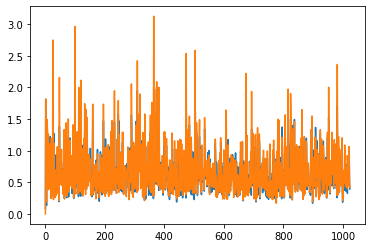

In [90]:
import matplotlib.pyplot as plt
plt.plot(lambdas[0,:,0].detach())
plt.plot(true_lambdas[0,:,0].detach())

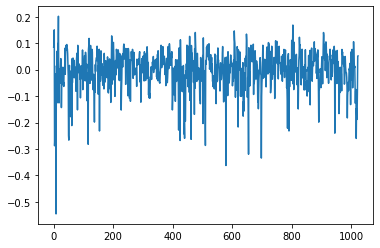

In [93]:
plt.plot((lambdas - true_lambdas)[123,:,0].detach())

In [46]:
true_lambdas[0,:,0]

tensor([5.5312e-05, 1.4561e+00, 1.2694e+00,  ..., 8.9697e-01, 8.4369e-01,
        9.1277e-01], grad_fn=<SelectBackward>)

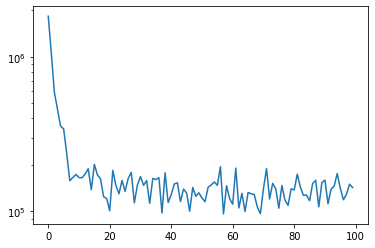

In [99]:
plt.plot([l+1400000 for l in losses])
plt.yscale('log')

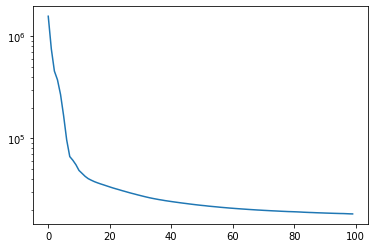

In [100]:
plt.plot([l + 1700000 for l in val_losses])
plt.yscale('log')

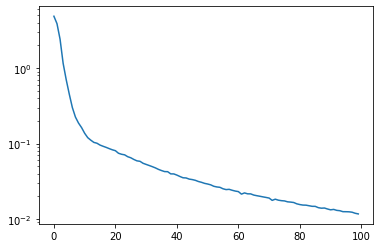

In [101]:
plt.plot(mses)
plt.yscale('log')

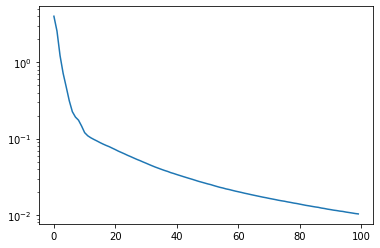

In [102]:
plt.plot(val_mses)
plt.yscale('log')

In [103]:
import zipfile
with zipfile.ZipFile('art_data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')